# Step 10 - Geodesic distances 

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import splu

#from util import veclen, normalized

In [2]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [4]:
lith_block, fault_block = gp.compute_model(interp_data)

In [5]:
print(lith_block.shape)

(2, 38400)


In [6]:
ver , sim = gp.get_surfaces(interp_data, lith_block[1])

In [7]:
# gp.plotting.plot_surfaces_3D(geo_data, ver, sim)

In [8]:
print(len(ver[3][:,0]))

707


In [9]:
coord = np.vstack((ver[0], ver[1], ver[2], ver[3]))
print(coord.shape)
print(coord[:,0].shape)

(2828, 3)
(2828,)


In [10]:
def set_axes_radius(ax, origin, radius):
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)

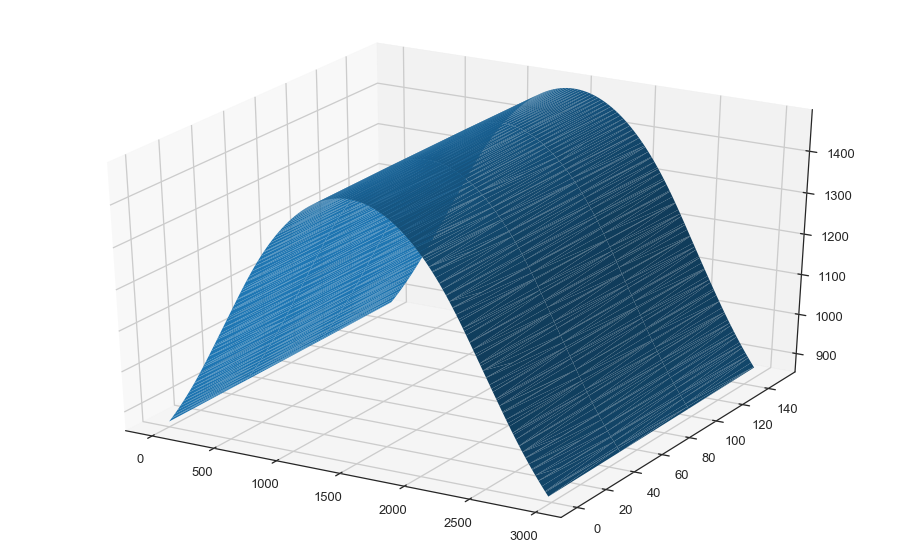

In [11]:
fig = plt.figure(figsize=(16,10))

# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(ver[0][:,0], ver[0][:,1], ver[0][:,2], triangles=sim[0])
# ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim, cmap=plt.cm.Spectral)
#ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim, cmap=plt.cm.Spectral)
#ax.plot_trisurf(ver[3][:,0], ver[3][:,1], ver[3][:,2], triangles=sim, cmap=plt.cm.Spectral)
#set_axes_equal(ax) 
# set 

In [12]:
def veclen(vectors):
    """ return L2 norm (vector length) along the last axis, for example to compute the length of an array of vectors """
    return np.sqrt(np.sum(vectors**2, axis=-1))

def normalized(vectors):
    """ normalize array of vectors along the last axis """
    return vectors / veclen(vectors)[..., np.newaxis]


def compute_mesh_laplacian(verts, tris):
    """
    computes a sparse matrix representing the discretized laplace-beltrami operator of the mesh
    given by n vertex positions ("verts") and a m triangles ("tris") 
    
    verts: (n, 3) array (float)
    tris: (m, 3) array (int) - indices into the verts array
    computes the conformal weights ("cotangent weights") for the mesh, ie:
    w_ij = - .5 * (cot \alpha + cot \beta)
    See:
        Olga Sorkine, "Laplacian Mesh Processing"
        and for theoretical comparison of different discretizations, see 
        Max Wardetzky et al., "Discrete Laplace operators: No free lunch"
    returns matrix L that computes the laplacian coordinates, e.g. L * x = delta
    """
    n = len(verts)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
        vi1 = tris[:,i1] # vertex index of i1
        vi2 = tris[:,i2]
        vi3 = tris[:,i3]
        # vertex vi1 faces the edge between vi2--vi3
        # compute the angle at v1
        # add cotangent angle at v1 to opposite edge v2--v3
        # the cotangent weights are symmetric
        u = verts[vi2] - verts[vi1]
        v = verts[vi3] - verts[vi1]
        cotan = (u * v).sum(axis=1) / veclen(np.cross(u, v))
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sparse.csr_matrix((W_ij, (I, J)), shape=(n, n))
    # compute diagonal entries
    L = L - sparse.spdiags(L * np.ones(n), 0, n, n)
    L = L.tocsr()
    # area matrix
    e1 = verts[tris[:,1]] - verts[tris[:,0]]
    e2 = verts[tris[:,2]] - verts[tris[:,0]]
    n = np.cross(e1, e2)
    triangle_area = .5 * veclen(n)
    # compute per-vertex area
    vertex_area = np.zeros(len(verts))
    ta3 = triangle_area / 3
    for i in range(tris.shape[1]): # Jan: changed xrange to range
        bc = np.bincount(tris[:,i].astype(int), ta3)
        vertex_area[:len(bc)] += bc
    VA = sparse.spdiags(vertex_area, 0, len(verts), len(verts))
    return L, VA


class GeodesicDistanceComputation(object):
    """ 
    Computation of geodesic distances on triangle meshes using the heat method from the impressive paper
        Geodesics in Heat: A New Approach to Computing Distance Based on Heat Flow
        Keenan Crane, Clarisse Weischedel, Max Wardetzky
        ACM Transactions on Graphics (SIGGRAPH 2013)
    Example usage:
        >>> compute_distance = GeodesicDistanceComputation(vertices, triangles)
        >>> distance_of_each_vertex_to_vertex_0 = compute_distance(0)
    """

    def __init__(self, verts, tris, m=10.0):
        self._verts = verts
        self._tris = tris
        # precompute some stuff needed later on
        e01 = verts[tris[:,1]] - verts[tris[:,0]]
        e12 = verts[tris[:,2]] - verts[tris[:,1]]
        e20 = verts[tris[:,0]] - verts[tris[:,2]]
        self._triangle_area = .5 * veclen(np.cross(e01, e12))
        unit_normal = normalized(np.cross(normalized(e01), normalized(e12)))
        self._unit_normal_cross_e01 = np.cross(unit_normal, e01)
        self._unit_normal_cross_e12 = np.cross(unit_normal, e12)
        self._unit_normal_cross_e20 = np.cross(unit_normal, e20)
        # parameters for heat method
        h = np.mean(list(map(veclen, [e01, e12, e20]))) # Jan: converted to list
        t = m * h ** 2
        # pre-factorize poisson systems
        Lc, A = compute_mesh_laplacian(verts, tris)
        self._factored_AtLc = splu((A - t * Lc).tocsc()).solve
        self._factored_L = splu(Lc.tocsc()).solve

    def __call__(self, idx):
        """ 
        computes geodesic distances to all vertices in the mesh
        idx can be either an integer (single vertex index) or a list of vertex indices
        or an array of bools of length n (with n the number of vertices in the mesh) 
        """
        u0 = np.zeros(len(self._verts))
        u0[idx] = 1.0
        # heat method, step 1
        u = self._factored_AtLc(u0).ravel()
        # heat method step 2
        grad_u = 1 / (2 * self._triangle_area)[:,np.newaxis] * (
              self._unit_normal_cross_e01 * u[self._tris[:,2]][:,np.newaxis]
            + self._unit_normal_cross_e12 * u[self._tris[:,0]][:,np.newaxis]
            + self._unit_normal_cross_e20 * u[self._tris[:,1]][:,np.newaxis]
        )
        X = - grad_u / veclen(grad_u)[:,np.newaxis]
        # heat method step 3
        div_Xs = np.zeros(len(self._verts))
        for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
            vi1, vi2, vi3 = self._tris[:,i1], self._tris[:,i2], self._tris[:,i3]
            e1 = self._verts[vi2] - self._verts[vi1]
            e2 = self._verts[vi3] - self._verts[vi1]
            e_opp = self._verts[vi3] - self._verts[vi2]
            cot1 = 1 / np.tan(np.arccos( 
                (normalized(-e2) * normalized(-e_opp)).sum(axis=1)))
            cot2 = 1 / np.tan(np.arccos(
                (normalized(-e1) * normalized( e_opp)).sum(axis=1)))
            div_Xs += np.bincount(
                vi1.astype(int), 
        0.5 * (cot1 * (e1 * X).sum(axis=1) + cot2 * (e2 * X).sum(axis=1)), 
        minlength=len(self._verts))
        phi = self._factored_L(div_Xs).ravel()
        phi -= phi.min()
        return phi

In [24]:
print(sim[1].shape)
print(ver[1].shape)

(1078, 3)
(713, 3)


In [37]:
compute_distance = GeodesicDistanceComputation(ver[1], sim[1])

In [38]:
point = 300

In [39]:
distance_of_each_vertex_to_vertex_0 = compute_distance(point)

In [40]:
# distance_of_each_vertex_to_vertex_0

In [41]:
# ver[0][0][0]

In [42]:
domain = pd.read_csv("domain3d.csv")

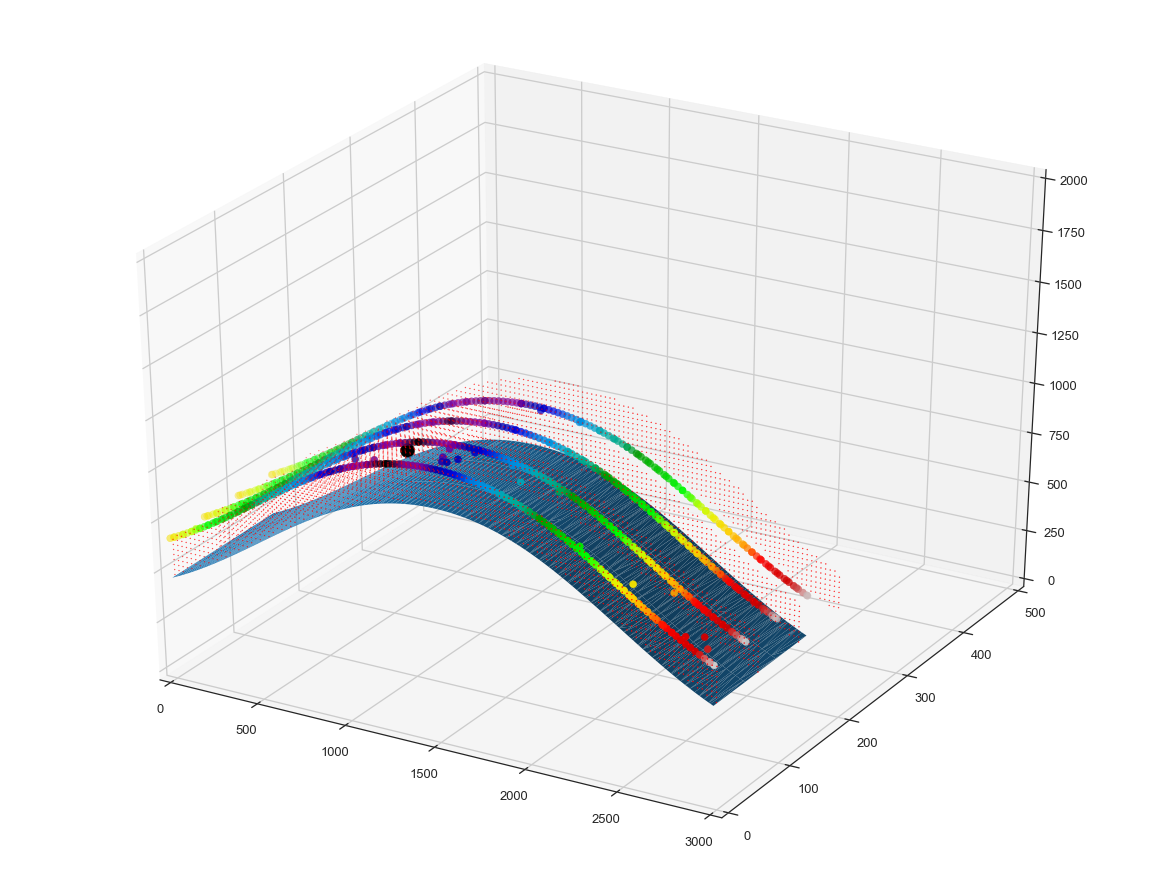

In [50]:

fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,500)
a = ax.scatter3D(xs=ver[1][:,0],ys=ver[1][:,1],zs=ver[1][:,2], c=distance_of_each_vertex_to_vertex_0, cmap='nipy_spectral', s=50)
# a = ax.scatter3D(xs=ver[2][:,0],ys=ver[2][:,1],zs=ver[2][:,2], c='black', cmap='nipy_spectral', s=50)
b = ax.scatter3D(xs=ver[1][point][0],ys=ver[1][point][1],zs=ver[1][point][2], c='black', s=200)
c = ax.scatter3D(xs=domain.X,ys=domain.Y,zs=domain.Z, c='red', s=1)
d = ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])



# fig.colorbar(a, orientation='horizontal')

In [23]:
%%time
for i in range(500000):
    distance_of_each_vertex_to_vertex = compute_distance(0)

Wall time: 18min 39s
